In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from utils.ModifiedDeepestLSTMTinyPilotNet import DeepestLSTMTinyPilotNet
from utils.load_dataset import CARLADataset
from torch.utils.data import DataLoader


# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepestLSTMTinyPilotNet((288, 200, 6), 3, 4)
model.load_state_dict(torch.load("models/v6.1_11 epochs.pth"))
model = model.to(device)
model.eval()

# Store ground truth and predictions
ground_truth = []
predictions = []

# Load the validation dataset
val_dataset = CARLADataset("../data/noisy_data_tm/val/")
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)


# Loop over validation data
with torch.no_grad():
    for images, speeds, hlc, controls_true in val_dataloader:
        images = images.to(device)
        speeds = speeds.to(device)
        controls_true = controls_true.to(device)
        hlc = hlc.to(device)

        # forward pass to get outputs
        controls_pred = model(images, speeds, hlc)

        ground_truth.extend(controls_true.cpu().numpy())
        predictions.extend(controls_pred.cpu().numpy())

# Convert lists to numpy arrays
ground_truth = np.array(ground_truth)
predictions = np.array(predictions)

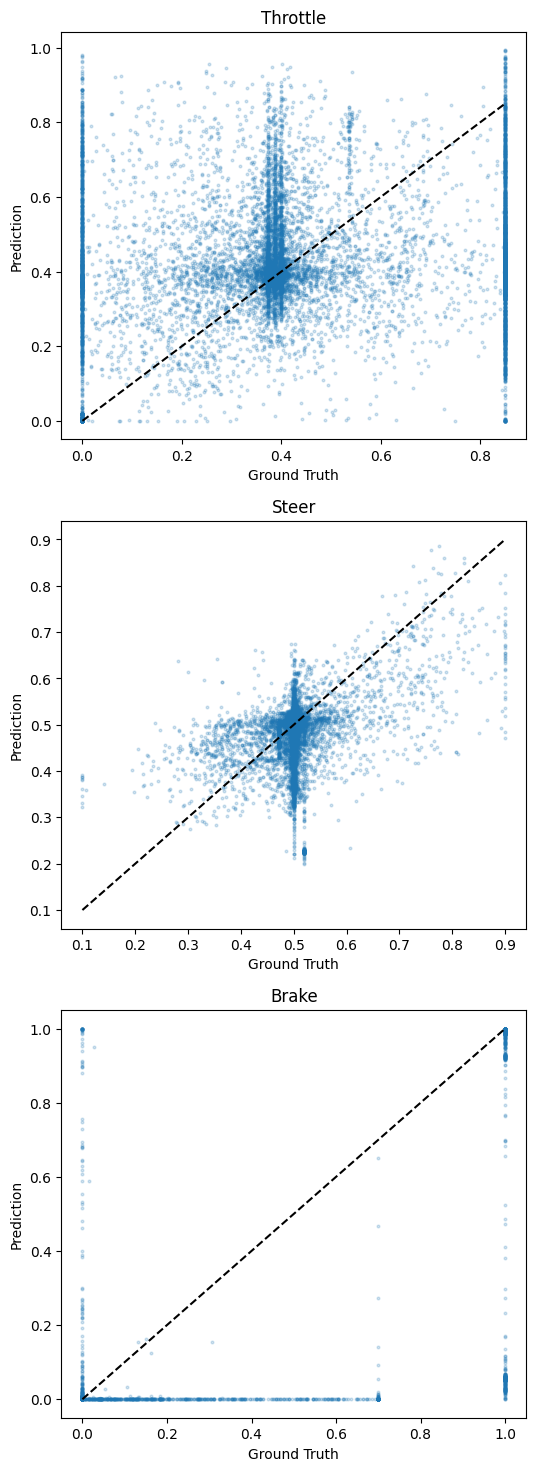

In [2]:
# Plot
fig, axs = plt.subplots(3, figsize=(6,18))

controls = ['Throttle', 'Steer', 'Brake']
for i in range(3):
    axs[i].scatter(ground_truth[:, i], predictions[:, i], s=15, marker='.', alpha=0.2)
    axs[i].plot([ground_truth[:, i].min(), ground_truth[:, i].max()], [ground_truth[:, i].min(), ground_truth[:, i].max()], 'k--')
    axs[i].set_xlabel('Ground Truth')
    axs[i].set_ylabel('Prediction')
    axs[i].set_title(controls[i])
    
plt.show()

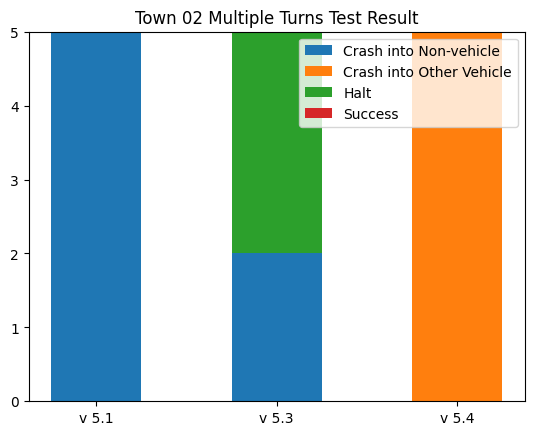

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = (
    "v 5.1",
    "v 5.3",
    "v 5.4",
)

weight_counts = {
    "Crash into Non-vehicle": np.array([5, 2, 0]),
    "Crash into Other Vehicle": np.array([0, 0, 5]),
    "Halt": np.array([0, 3, 0]),
    "Success": np.array([0, 0, 0]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Town 02 Multiple Turns Test Result")
ax.legend(loc="upper right")

plt.show()